In [1]:
# import here
import os
import PIL
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.utils.data.sampler as sampler
from torch import nn, optim
import torch.nn.functional as F
%matplotlib inline
from torch.utils.tensorboard import SummaryWriter
import torchvision

---
# Load The Data

In [2]:
# Load pickled data
training_file = r"C:\Users\Uchiha\data\traffic-sign-recognition-master\train.p"
validation_file = r"C:\Users\Uchiha\data\traffic-sign-recognition-master\valid.p"
testing_file = r"C:\Users\Uchiha\data\traffic-sign-recognition-master\test.p"


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

# Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

In [3]:
# Number of training examples
n_train = len(X_train)
# Number of validation examples.
n_valid = len(X_valid)
# Number of testing examples.
n_test = len(X_test)

# The shape of an traffic sign image
image_shape = X_train[0].shape[:-1]

# Number of unique classes/labels in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_valid)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


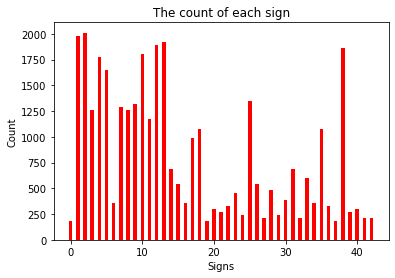

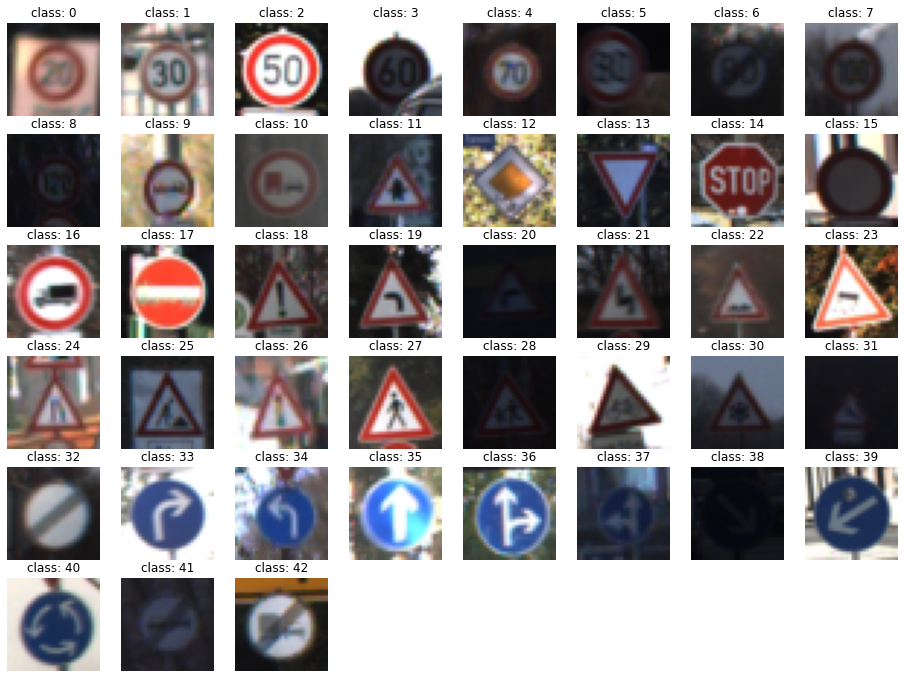

In [4]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

# Design and Test a Baseline Model Architecture

## Custom Dataset & DataLoader

In [5]:
class PickledDataset(Dataset):
    def __init__(self, file_path, transform=None):
        with open(file_path, mode='rb') as f:
            data = pickle.load(f)
            self.features = data['features']
            self.labels = data['labels']
            self.count = len(self.labels)
            self.transform = transform
        
    def __getitem__(self, index):
        feature = self.features[index]
        if self.transform is not None:
            feature = self.transform(feature)
        return (feature, self.labels[index])

    def __len__(self):
        return self.count

## Baseline Model

In [6]:
class BaselineNet(nn.Module):
    def __init__(self, gray=False):
        super(BaselineNet, self).__init__()
        input_chan = 1 if gray else 3
        self.conv1 = nn.Conv2d(input_chan, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 43)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## Training

In [7]:
lr = 0.001
batch_size = 64

train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, to_device)
valid_loader = WrappedDataLoader(valid_loader, to_device)
test_loader = WrappedDataLoader(test_loader, to_device)

## Visualizing during workflow using TensorBoard

For efficient measurements and tracking performance during training we will use TensorBoard, summary of all the runs will be stored in runs folder of your working directory. 

To access tensorboard run the below code in terminal.

'tensorboard --logdir=runs'

In [10]:
comment = f' Model1_learning_rate={lr}'
tb = SummaryWriter(comment=comment)
model1 = BaselineNet().to(device)
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
#to know more about the architecture of our network
tb.add_graph(model1, images)
tb.close()

In [11]:
model1 = BaselineNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model1.parameters(), lr=lr, momentum=0.9)
n_epochs = 20

In [12]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [13]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [14]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    loss_values =[]
    valid_loss_values=[]
    
    for epoch in range(epochs):
        train_loss = 0.0
        valid_loss = 0.0
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        loss_values.append(train_loss)
        
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_loss_values.append(valid_loss)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            
        #Tracking required metrics in real time   
        tb.add_scalar('Training Loss', train_loss, epoch)
        tb.add_scalar('Validation Loss', valid_loss, epoch)
        tb.add_scalar('Accuracy', valid_accuracy, epoch)
    
        for name, weight in model.named_parameters():
            tb.add_histogram(name, weight, epoch)
            tb.add_histogram(f'{name}.grad', weight.grad, epoch)
                    
tb.close()
             

In [15]:
def evaluate(model, loss_func, dl):
    model.eval()
    with torch.no_grad():
        losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in dl])
        test_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        test_accuracy = np.sum(corrects) / np.sum(nums) * 100
        
        
    print(f"Test loss: {test_loss:.6f}\t"
          f"Test accruacy: {test_accuracy:.3f}%")


In [16]:
fit(n_epochs, model1, criterion, optimizer, train_loader, valid_loader)
evaluate(model1, criterion, test_loader)

[Epoch 1/20] Train loss: 3.678935	Validation loss: 3.579751	 Validation accruacy: 4.694%
[Epoch 2/20] Train loss: 3.482446	Validation loss: 3.574117	 Validation accruacy: 6.893%
[Epoch 3/20] Train loss: 3.448419	Validation loss: 3.533217	 Validation accruacy: 7.120%
[Epoch 4/20] Train loss: 3.322765	Validation loss: 3.304711	 Validation accruacy: 17.868%
[Epoch 5/20] Train loss: 2.712905	Validation loss: 2.423113	 Validation accruacy: 32.313%
[Epoch 6/20] Train loss: 1.786106	Validation loss: 1.646075	 Validation accruacy: 54.172%
[Epoch 7/20] Train loss: 1.216611	Validation loss: 1.254047	 Validation accruacy: 63.696%
[Epoch 8/20] Train loss: 0.891946	Validation loss: 0.984174	 Validation accruacy: 72.948%
[Epoch 9/20] Train loss: 0.697410	Validation loss: 0.994522	 Validation accruacy: 71.519%
[Epoch 10/20] Train loss: 0.558980	Validation loss: 0.803580	 Validation accruacy: 78.367%
[Epoch 11/20] Train loss: 0.463979	Validation loss: 0.764913	 Validation accruacy: 79.932%
[Epoch 12/2

---
# Experiment and fine-tuning

## Data preprocessing

In [17]:
class CLAHE_GRAY:
    def __init__(self, clipLimit=2.5, tileGridSize=(4, 4)):
        self.clipLimit = clipLimit
        self.tileGridSize = tileGridSize

    def __call__(self, im):
        img_y = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)[:,:,0]
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=self.tileGridSize)
        img_y = clahe.apply(img_y)
        img_output = img_y.reshape(img_y.shape + (1,))
        return img_output

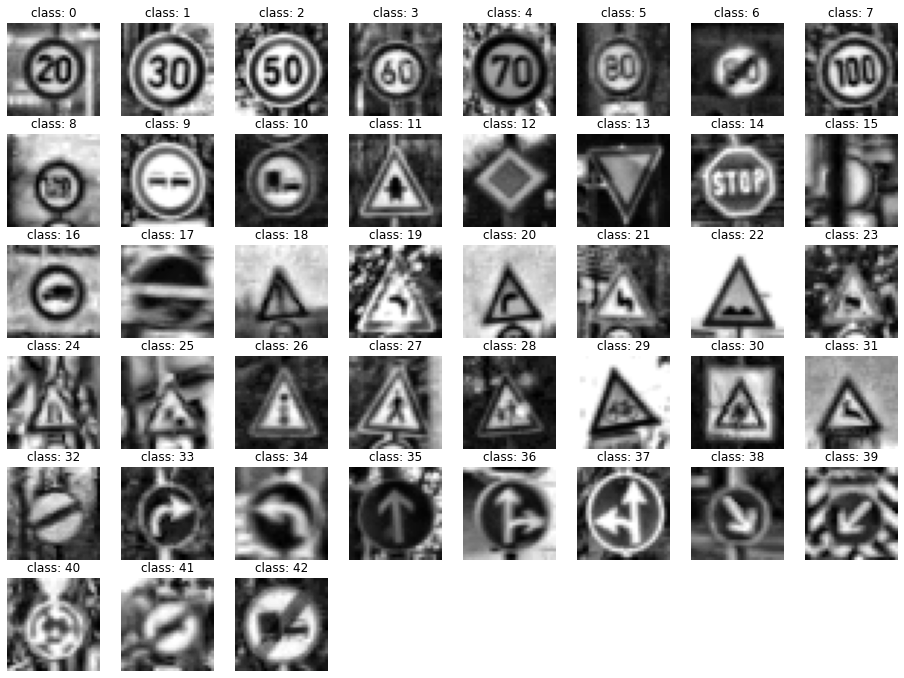

In [18]:
clahe = CLAHE_GRAY()
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(clahe(X_train[i]).squeeze(), cmap='gray')

In [19]:
data_transforms = transforms.Compose([
    CLAHE_GRAY(),
    transforms.ToTensor()
])

train_dataset = PickledDataset(training_file, transform=data_transforms)
valid_dataset = PickledDataset(validation_file, transform=data_transforms)
test_dataset = PickledDataset(testing_file, transform=data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

In [20]:
comment =f' Model_2_learning_rate={lr}'
tb = SummaryWriter(comment=comment)
model2 = BaselineNet(gray=True).to(device)

optimizer = optim.SGD(model2.parameters(), lr=lr, momentum=0.9)
fit(n_epochs, model2, criterion, optimizer, train_loader, valid_loader)
evaluate(model2, criterion, test_loader)

[Epoch 1/20] Train loss: 3.717671	Validation loss: 3.686267	 Validation accruacy: 5.442%
[Epoch 2/20] Train loss: 3.569353	Validation loss: 3.569551	 Validation accruacy: 4.308%
[Epoch 3/20] Train loss: 3.470881	Validation loss: 3.549702	 Validation accruacy: 7.120%
[Epoch 4/20] Train loss: 3.450396	Validation loss: 3.526370	 Validation accruacy: 9.955%
[Epoch 5/20] Train loss: 3.331807	Validation loss: 3.267828	 Validation accruacy: 20.680%
[Epoch 6/20] Train loss: 2.621579	Validation loss: 2.146071	 Validation accruacy: 40.363%
[Epoch 7/20] Train loss: 1.545882	Validation loss: 1.327899	 Validation accruacy: 59.456%
[Epoch 8/20] Train loss: 1.004534	Validation loss: 0.977151	 Validation accruacy: 69.206%
[Epoch 9/20] Train loss: 0.760525	Validation loss: 0.800968	 Validation accruacy: 74.943%
[Epoch 10/20] Train loss: 0.622256	Validation loss: 0.690832	 Validation accruacy: 79.841%
[Epoch 11/20] Train loss: 0.517136	Validation loss: 0.603697	 Validation accruacy: 81.905%
[Epoch 12/20

## Save preprocessed images

In [21]:
def preprocess(path):
    if not os.path.exists(f"{path}/train_gray.p"):
        for dataset in ['train', 'valid', 'test']:
            with open(f"{path}/{dataset}.p", mode='rb') as f:
                data = pickle.load(f)
                X = data['features']
                y = data['labels']

            clahe = CLAHE_GRAY()
            for i in range(len(X)):
                X[i] = clahe(X[i])

            X = X[:, :, :, 0]
            with open(f"{path}/{dataset}_gray.p", "wb") as f:
                pickle.dump({"features": X.reshape(
                    X.shape + (1,)), "labels": y}, f)

In [22]:
preprocess(r'C:\Users\Uchiha\data\traffic-sign-recognition-master')
training_file = r"C:\Users\Uchiha\data\traffic-sign-recognition-master\train_gray.p"
validation_file = r"C:\Users\Uchiha\data\traffic-sign-recognition-master\valid_gray.p"
testing_file = r"C:\Users\Uchiha\data\traffic-sign-recognition-master\test_gray.p"

In [23]:
train_dataset = PickledDataset(training_file, transform=transforms.ToTensor())
valid_dataset = PickledDataset(validation_file, transform=transforms.ToTensor())
test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

## Handling imbalanced dataset

### Flipping

In [24]:
def extend_dataset(dataset):
    X = dataset.features
    y = dataset.labels
    num_classes = 43
    
    X_extended = np.empty([0] + list(dataset.features.shape)[1:], dtype=dataset.features.dtype)
    y_extended = np.empty([0], dtype = dataset.labels.dtype)
    
    horizontally_flippable = [11, 12, 13, 15, 17, 18, 22, 26, 30, 35]
    vertically_flippable = [1, 5, 12, 15, 17]
    both_flippable = [32, 40]
    cross_flippable = np.array([
        [19, 20],
        [33, 34],
        [36, 37],
        [38, 39],
        [20, 19],
        [34, 33],
        [37, 36],
        [39, 38]
    ])
    
    for c in range(num_classes):
        X_extended = np.append(X_extended, X[y==c], axis=0)  
        
        if c in horizontally_flippable:
            X_extended = np.append(X_extended, X[y==c][:,:,::-1,:], axis=0)
        if c in vertically_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,:,:], axis=0)
        if c in cross_flippable[:,0]:
            flip_c = cross_flippable[cross_flippable[:,0]==c][0][1]
            X_extended = np.append(X_extended, X[y==flip_c][:,:,::-1,:], axis=0)
        if c in both_flippable:
            X_extended = np.append(X_extended, X[y==c][:,::-1,::-1,:], axis=0)
        
        y_extended = np.append(y_extended, np.full(X_extended.shape[0]-y_extended.shape[0], c, dtype=y_extended.dtype))
    
    dataset.features = X_extended
    dataset.labels = y_extended
    dataset.count = len(y_extended)
    
    return dataset

In [25]:
train_dataset = extend_dataset(train_dataset)
train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, shuffle=True), to_device)

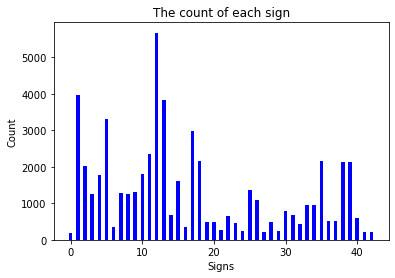

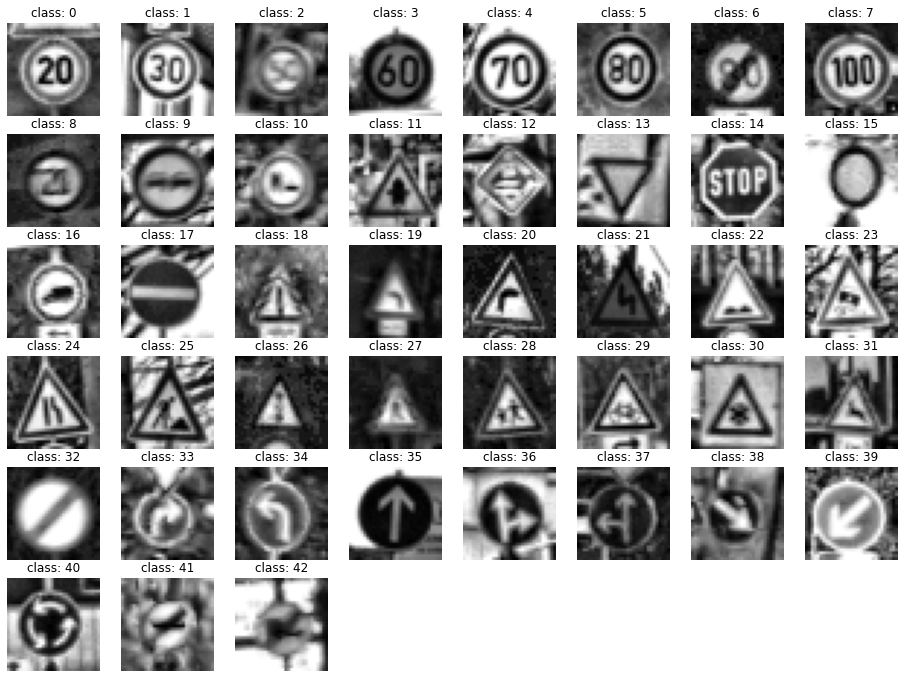

In [26]:
### Data exploration visualization.
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_dataset.labels), 0.5, color='blue')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_dataset.labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_dataset.features[i].squeeze(), cmap='gray')

In [27]:
comment = f' Model_3_learning_rate={lr}'
tb=SummaryWriter(comment=comment)

model3 = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model3.parameters(), lr=lr, momentum=0.9)
fit(n_epochs, model3, criterion, optimizer, train_loader, valid_loader)
evaluate(model3, criterion, test_loader)

[Epoch 1/20] Train loss: 3.500386	Validation loss: 3.605446	 Validation accruacy: 6.803%
[Epoch 2/20] Train loss: 2.898886	Validation loss: 2.465108	 Validation accruacy: 33.515%
[Epoch 3/20] Train loss: 1.466216	Validation loss: 1.361029	 Validation accruacy: 59.002%
[Epoch 4/20] Train loss: 0.861159	Validation loss: 0.937741	 Validation accruacy: 72.880%
[Epoch 5/20] Train loss: 0.623842	Validation loss: 0.711721	 Validation accruacy: 79.887%
[Epoch 6/20] Train loss: 0.481653	Validation loss: 0.597156	 Validation accruacy: 83.356%
[Epoch 7/20] Train loss: 0.388143	Validation loss: 0.504732	 Validation accruacy: 86.190%
[Epoch 8/20] Train loss: 0.321990	Validation loss: 0.443042	 Validation accruacy: 87.687%
[Epoch 9/20] Train loss: 0.274060	Validation loss: 0.478666	 Validation accruacy: 85.646%
[Epoch 10/20] Train loss: 0.237588	Validation loss: 0.417775	 Validation accruacy: 88.254%
[Epoch 11/20] Train loss: 0.207694	Validation loss: 0.389862	 Validation accruacy: 88.753%
[Epoch 12

### Augmentation

In [28]:
train_dataset = extend_dataset(PickledDataset(training_file))

class_sample_count = np.bincount(train_dataset.labels)
weights = 1 / np.array([class_sample_count[y] for y in train_dataset.labels])
samp = sampler.WeightedRandomSampler(weights, 43 * 20000)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)

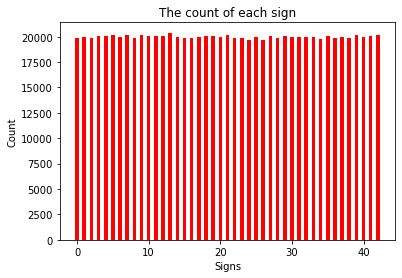

In [29]:
balanced_y_train = torch.LongTensor([]).to(device)

with torch.no_grad():
    for _, y in train_loader:
        balanced_y_train = torch.cat((balanced_y_train, y))

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(balanced_y_train.cpu().numpy()), 0.5, color='r')
ax.set_xlabel('Signs')
ax.set_ylabel('Count')
ax.set_title('The count of each sign')
plt.show()

In [30]:
train_data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomApply([
        transforms.RandomRotation(20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, translate=(0.2, 0.2), resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, shear=20, resample=PIL.Image.BICUBIC),
        transforms.RandomAffine(0, scale=(0.8, 1.2), resample=PIL.Image.BICUBIC)
    ]),
    transforms.ToTensor()
])
test_data_transforms = transforms.ToTensor()

train_dataset = extend_dataset(PickledDataset(training_file, transform=train_data_transforms))
valid_dataset = PickledDataset(validation_file, transform=test_data_transforms)
test_dataset = PickledDataset(testing_file, transform=test_data_transforms)

train_loader = WrappedDataLoader(DataLoader(train_dataset, batch_size=64, sampler=samp), to_device)
valid_loader = WrappedDataLoader(DataLoader(valid_dataset, batch_size=64, shuffle=False), to_device)
test_loader = WrappedDataLoader(DataLoader(test_dataset, batch_size=64, shuffle=False), to_device)

### Visualizing augmented data

In [31]:
def convert_image_np(img):
    img = img.numpy().transpose((1, 2, 0)).squeeze()
    return img

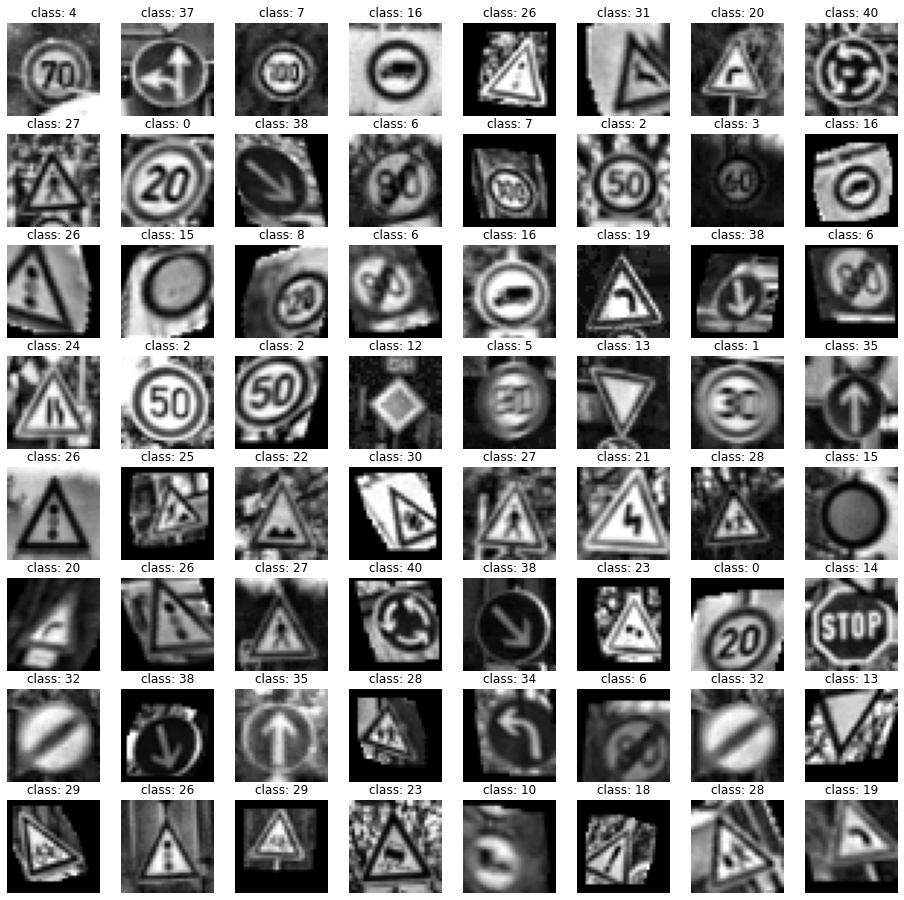

In [32]:
with torch.no_grad():
    x, y = next(iter(train_loader))
    plt.figure(figsize=(16, 16))
    for i in range(len(y)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('class: {}'.format(y[i]))
        plt.imshow(convert_image_np(x[i].cpu()), cmap='gray')

In [33]:
comment = f'Model_4_augmented_data_learning_rate={lr}'
tb = SummaryWriter(comment=comment)

model4 = BaselineNet(gray=True).to(device)
optimizer = optim.SGD(model4.parameters(), lr=lr, momentum=0.9)
fit(n_epochs, model4, criterion, optimizer, train_loader, valid_loader)
evaluate(model4, criterion, test_loader)

[Epoch 1/20] Train loss: 2.873950	Validation loss: 0.649300	 Validation accruacy: 81.995%
[Epoch 2/20] Train loss: 0.841759	Validation loss: 0.379719	 Validation accruacy: 89.909%
[Epoch 3/20] Train loss: 0.526087	Validation loss: 0.349583	 Validation accruacy: 91.043%
[Epoch 4/20] Train loss: 0.414083	Validation loss: 0.295746	 Validation accruacy: 93.152%
[Epoch 5/20] Train loss: 0.347360	Validation loss: 0.356417	 Validation accruacy: 92.676%
[Epoch 6/20] Train loss: 0.305263	Validation loss: 0.314993	 Validation accruacy: 92.494%
[Epoch 7/20] Train loss: 0.272743	Validation loss: 0.303553	 Validation accruacy: 93.900%
[Epoch 8/20] Train loss: 0.248956	Validation loss: 0.269841	 Validation accruacy: 94.036%
[Epoch 9/20] Train loss: 0.229291	Validation loss: 0.289195	 Validation accruacy: 93.991%
[Epoch 10/20] Train loss: 0.213782	Validation loss: 0.239953	 Validation accruacy: 94.739%
[Epoch 11/20] Train loss: 0.200194	Validation loss: 0.261735	 Validation accruacy: 94.444%
[Epoch 1

## Model

In [34]:
class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x

In [35]:
lr = 0.0001
comment = f' TrafficSignNet_Model_learning_rate={lr}'
tb = SummaryWriter(comment=comment)
model5 = TrafficSignNet().to(device)
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(model5, images)
tb.close()

In [36]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl, patience=10):
    wait = 0
    valid_loss_min = np.Inf
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
                torch.save(model.state_dict(), 'Model.pt')
                valid_loss_min = valid_loss
                wait = 0
            # Early stopping
            else:
                wait += 1
                if wait >= patience:
                    print(f"Terminated Training for Early Stopping at Epoch {epoch+1}")
                    return
        #Tracking required metrics        
        tb.add_scalar('Training Loss/(TrafficSignNet)', train_loss, epoch)
        tb.add_scalar('Validation Loss/(TrafficSignNet)', valid_loss, epoch)
        tb.add_scalar('Accuracy/(TrafficSignNet)', valid_accuracy, epoch)
    
        for name, weight in model.named_parameters():
            tb.add_histogram(name, weight, epoch)
            tb.add_histogram(f'{name}.grad', weight.grad, epoch)
                    
tb.close()

In [37]:
n_epochs = 100
optimizer = optim.Adam(model5.parameters(), lr=lr)
fit(n_epochs, model5, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/100] Train loss: 1.193513	Validation loss: 0.169032	 Validation accruacy: 96.190%
Validation loss decreased (inf --> 0.169032). Saving model...
[Epoch 2/100] Train loss: 0.573002	Validation loss: 0.105178	 Validation accruacy: 97.415%
Validation loss decreased (0.169032 --> 0.105178). Saving model...
[Epoch 3/100] Train loss: 0.425415	Validation loss: 0.085511	 Validation accruacy: 97.868%
Validation loss decreased (0.105178 --> 0.085511). Saving model...
[Epoch 4/100] Train loss: 0.346115	Validation loss: 0.080251	 Validation accruacy: 98.073%
Validation loss decreased (0.085511 --> 0.080251). Saving model...
[Epoch 5/100] Train loss: 0.297021	Validation loss: 0.069654	 Validation accruacy: 98.231%
Validation loss decreased (0.080251 --> 0.069654). Saving model...
[Epoch 6/100] Train loss: 0.263941	Validation loss: 0.071197	 Validation accruacy: 98.277%
[Epoch 7/100] Train loss: 0.240505	Validation loss: 0.077660	 Validation accruacy: 98.209%
[Epoch 8/100] Train loss: 0.22246

### Visualizing activation maps (TrafficSignNet model)

In [38]:
# Accessing Convolutional Layers

no_of_layers=0
conv_layers=[]

model_children=list(model5.children())

for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)

3


In [39]:
def get_random_images(num):
    test_dataset = PickledDataset(testing_file, transform=transforms.ToTensor())
    classes = len(set(y_train))
    indices = list(range(len(test_dataset)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    random_loader = DataLoader(test_dataset, 
                   sampler=sampler, batch_size=num)
    #random_loader = WrappedDataLoader(test_loader)#, to_device)
    
    dataiter = iter(random_loader)
    images, labels = dataiter.next()
    return images, labels

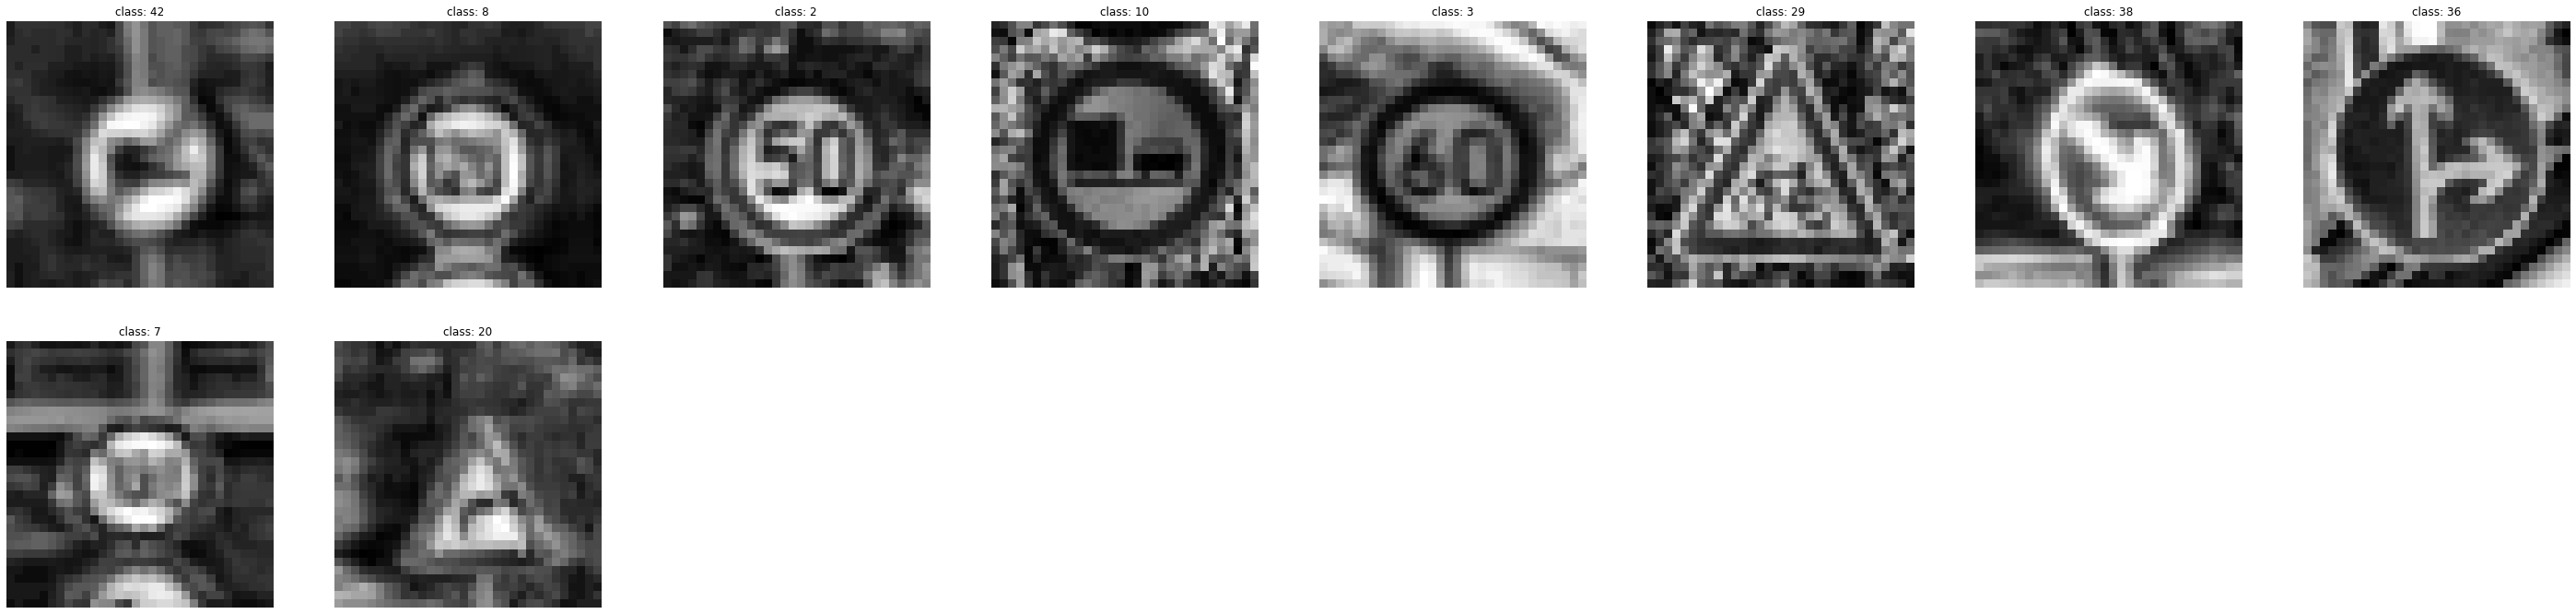

In [40]:
#Plotting images and their respective class before feeding to model
images, labels = get_random_images(10)
plt.figure(figsize=(50, 50))
for i in range(len(labels)):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    plt.title('class: {}'.format(labels[i]))
    plt.imshow(convert_image_np(images[i].cpu()), cmap='gray')

In [41]:
results = [conv_layers[0](images.to(device))]#.squeeze(0))]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results
len(outputs)

3

Conolution Layer  1


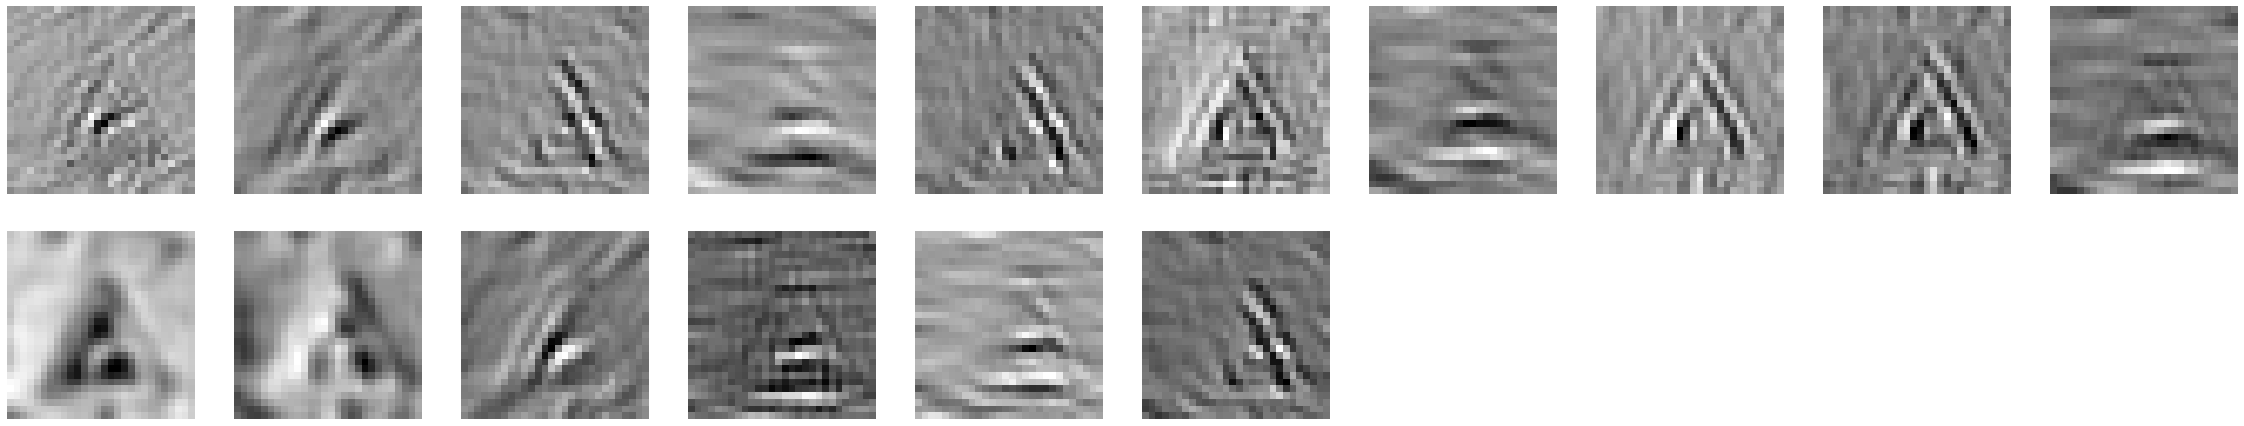

Conolution Layer  2


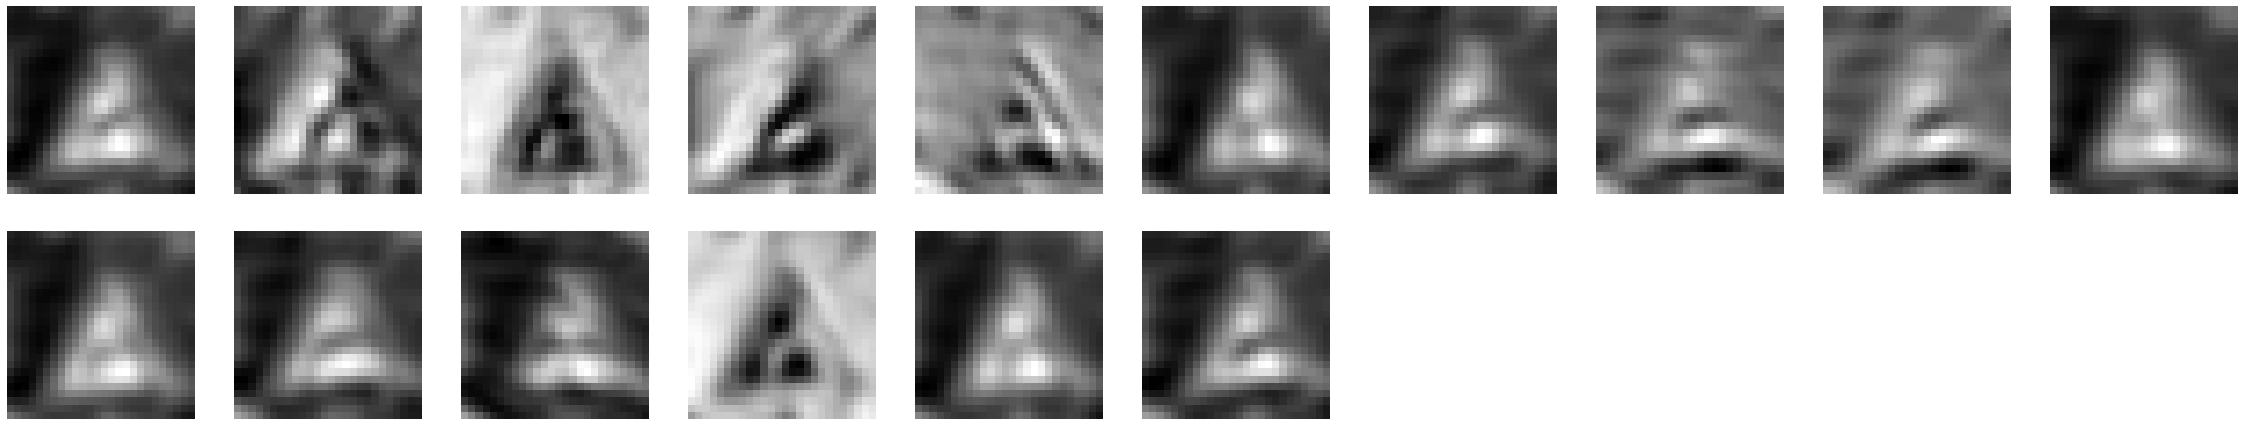

Conolution Layer  3


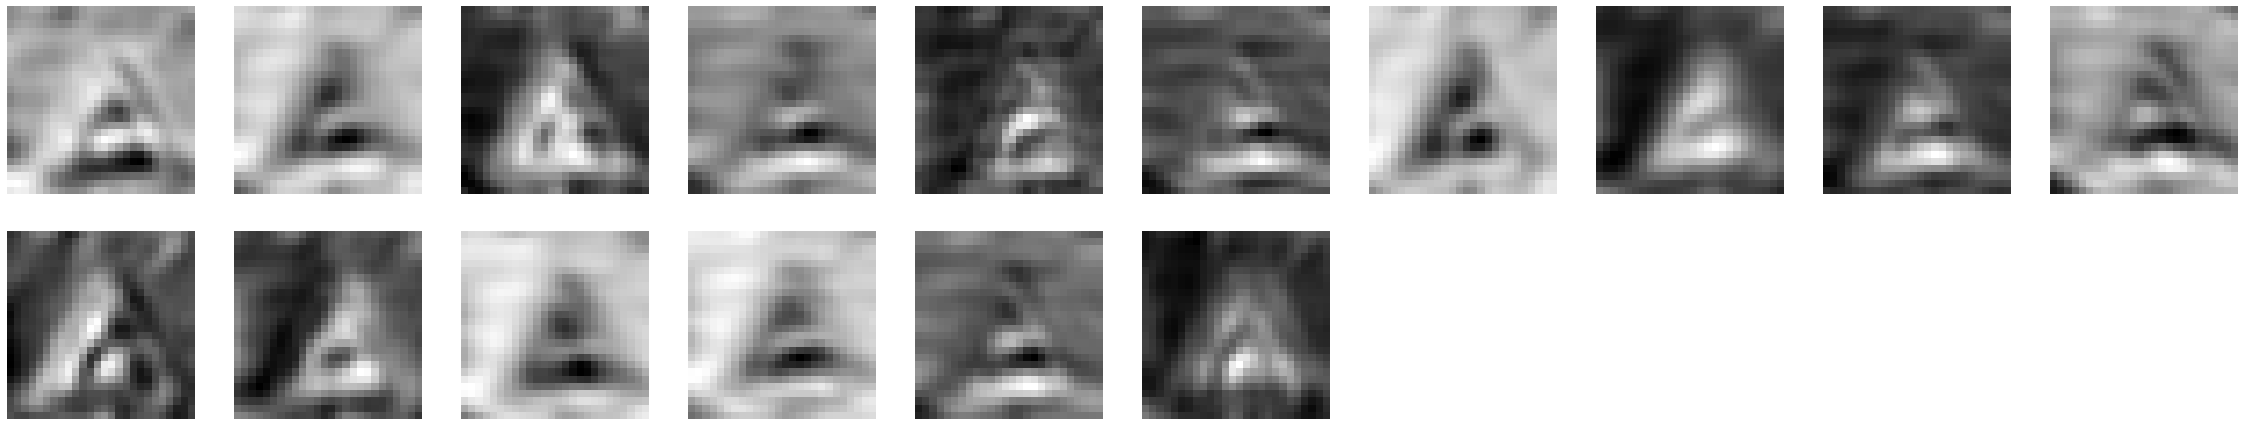

In [44]:
#Visualizing Feature maps (Plotting only 16 two dimenional images from each layer)
for num_layer in range(len(outputs)):
    plt.figure(figsize=(40, 20))
    layer_viz = outputs[num_layer][9, :, :, :].cpu()
    layer_viz = layer_viz.data
    
    print("Conolution Layer ", num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        #print(filter.shape)
        plt.subplot(5, 10, i+1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()

In [45]:
check_point = torch.load('Model.pt', map_location=device)
model5.load_state_dict(check_point)
evaluate(model5, criterion, test_loader)

Test loss: 0.038774	Test accruacy: 98.884%


### This section is commented and is recommended to run only for experiment 1 purposes

# Spatial transformer networks

In [46]:
'''class Stn(nn.Module):
    def __init__(self):
        super(Stn, self).__init__()
        # Spatial transformer localization-network
        self.loc_net = nn.Sequential(
            nn.Conv2d(1, 50, 7),
            nn.MaxPool2d(2, 2),
            nn.ELU(),
            nn.Conv2d(50, 100, 5),
            nn.MaxPool2d(2, 2),
            nn.ELU()
        )
        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(100 * 4 * 4, 100),
            nn.ELU(),
            nn.Linear(100, 3 * 2)
        )
        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))
        
    def forward(self, x):
        xs = self.loc_net(x)
        xs = xs.view(-1, 100 * 4 * 4)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x'''

In [47]:
'''class TrafficSignNet(nn.Module):
    def __init__(self):
        super(TrafficSignNet, self).__init__()
        self.stn = Stn()
        self.conv1 = nn.Conv2d(1, 100, 5)
        self.conv1_bn = nn.BatchNorm2d(100)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(100, 150, 3)
        self.conv2_bn = nn.BatchNorm2d(150)
        self.conv3 = nn.Conv2d(150, 250, 1)
        self.conv3_bn = nn.BatchNorm2d(250)
        self.fc1 = nn.Linear(250 * 3 * 3, 350)
        self.fc1_bn = nn.BatchNorm1d(350)
        self.fc2 = nn.Linear(350, 43)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.stn(x)
        x = self.pool(F.elu(self.conv1(x)))
        x = self.dropout(self.conv1_bn(x))
        x = self.pool(F.elu(self.conv2(x)))
        x = self.dropout(self.conv2_bn(x))
        x = self.pool(F.elu(self.conv3(x)))
        x = self.dropout(self.conv3_bn(x))
        x = x.view(-1, 250 * 3 * 3)
        x = F.elu(self.fc1(x))
        x = self.dropout(self.fc1_bn(x))
        x = self.fc2(x)
        return x'''

In [48]:
'''comment = f' Spatial_transformer_network_learning_rate={lr}'
tb = SummaryWriter(comment=comment)

model6 = TrafficSignNet().to(device)
images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images)

tb.add_image('images', grid)
tb.add_graph(model6, images)
tb.close()'''

D:\Anaconda\lib\site-packages\torch\nn\functional.py:3448: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
D:\Anaconda\lib\site-packages\torch\nn\functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


## Visualizing activation maps (STN model)

In [49]:
'''no_of_layers=0
conv_layers=[]

model_children=list(model6.children())

for child in model_children:
  if type(child)==nn.Conv2d:
    no_of_layers+=1
    conv_layers.append(child)
  elif type(child)==nn.Sequential:
    for layer in child.children():
      if type(layer)==nn.Conv2d:
        no_of_layers+=1
        conv_layers.append(layer)
print(no_of_layers)'''

3


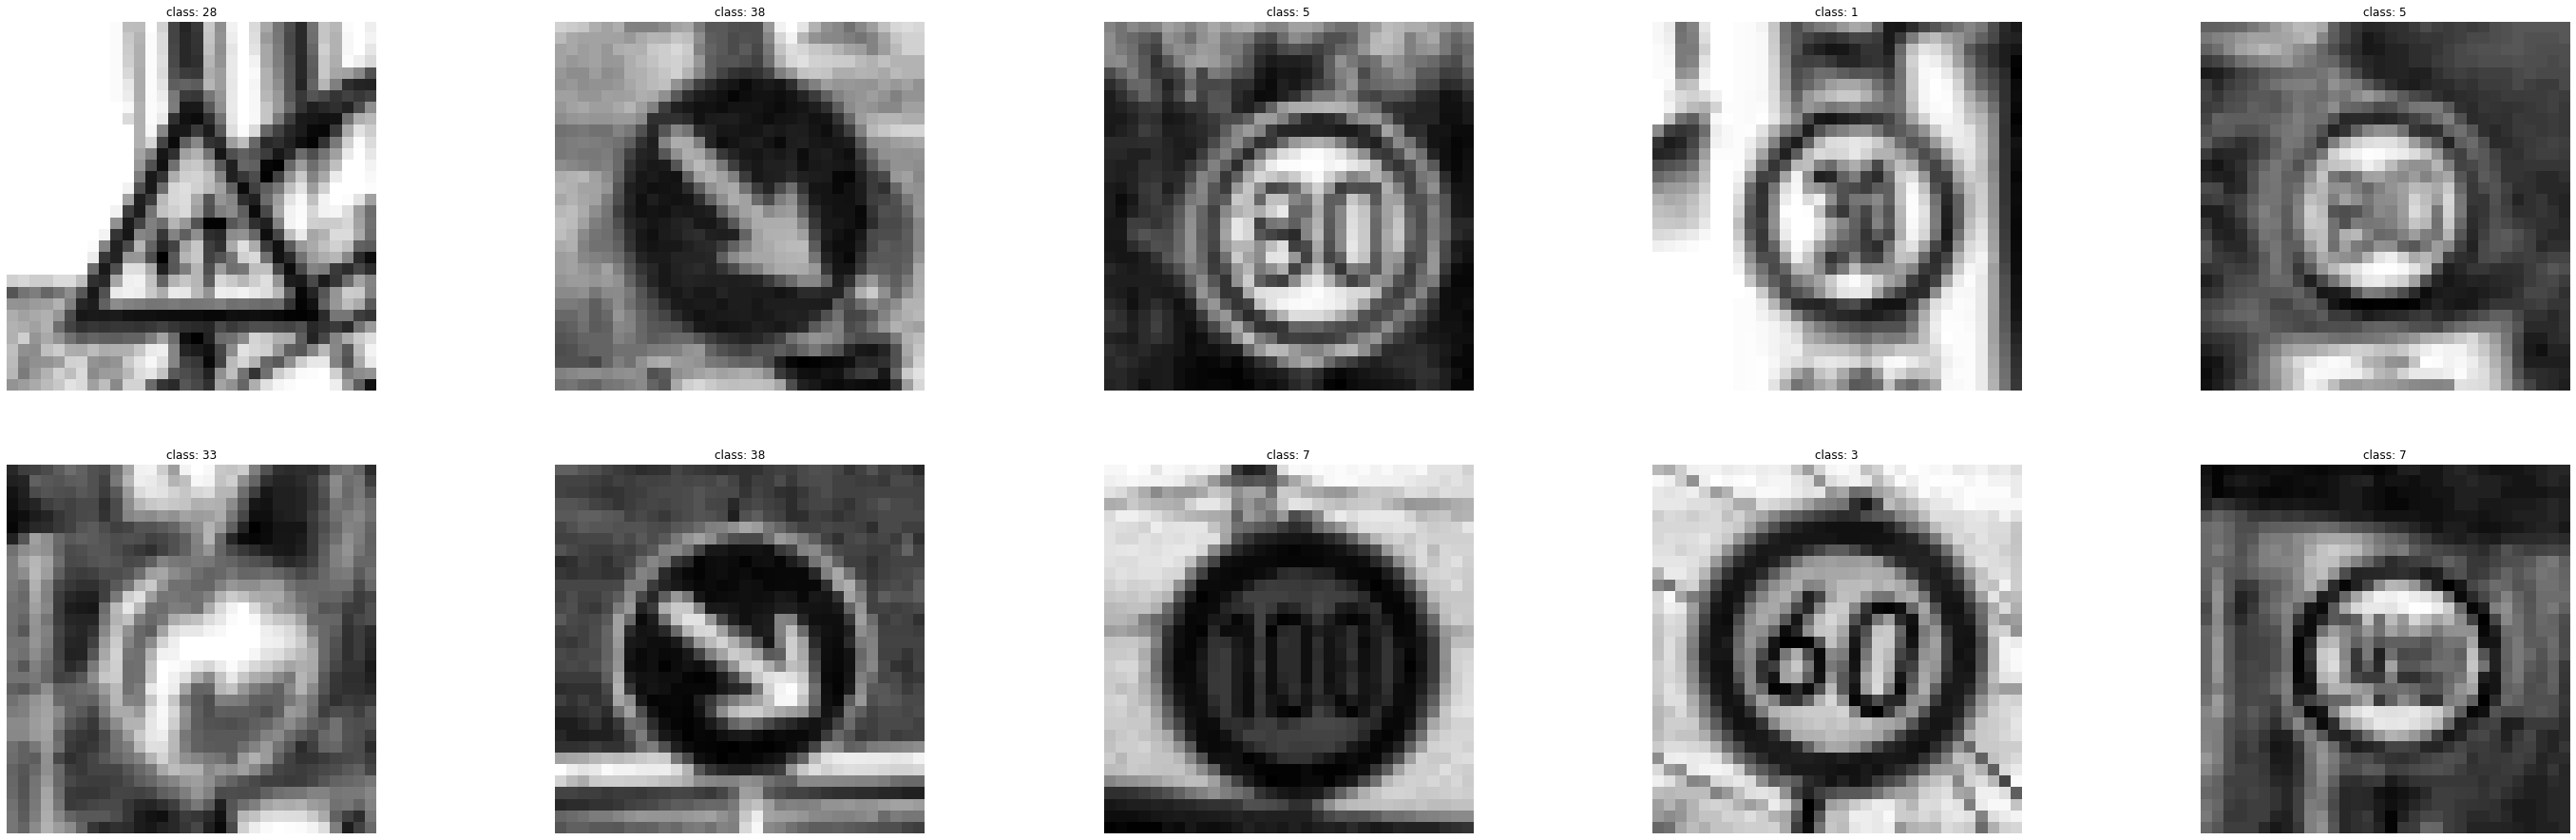

In [50]:
'''images, labels = get_random_images(10)
plt.figure(figsize=(50, 50))
for i in range(len(labels)):
    plt.subplot(6, 5, i+1)
    plt.axis('off')
    plt.title('class: {}'.format(labels[i]))
    plt.imshow(convert_image_np(images[i].cpu()), cmap='gray')'''

In [51]:
'''results = [conv_layers[0](images.to(device))]#.squeeze(0))]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results
len(outputs)'''

3

conv Layer  1


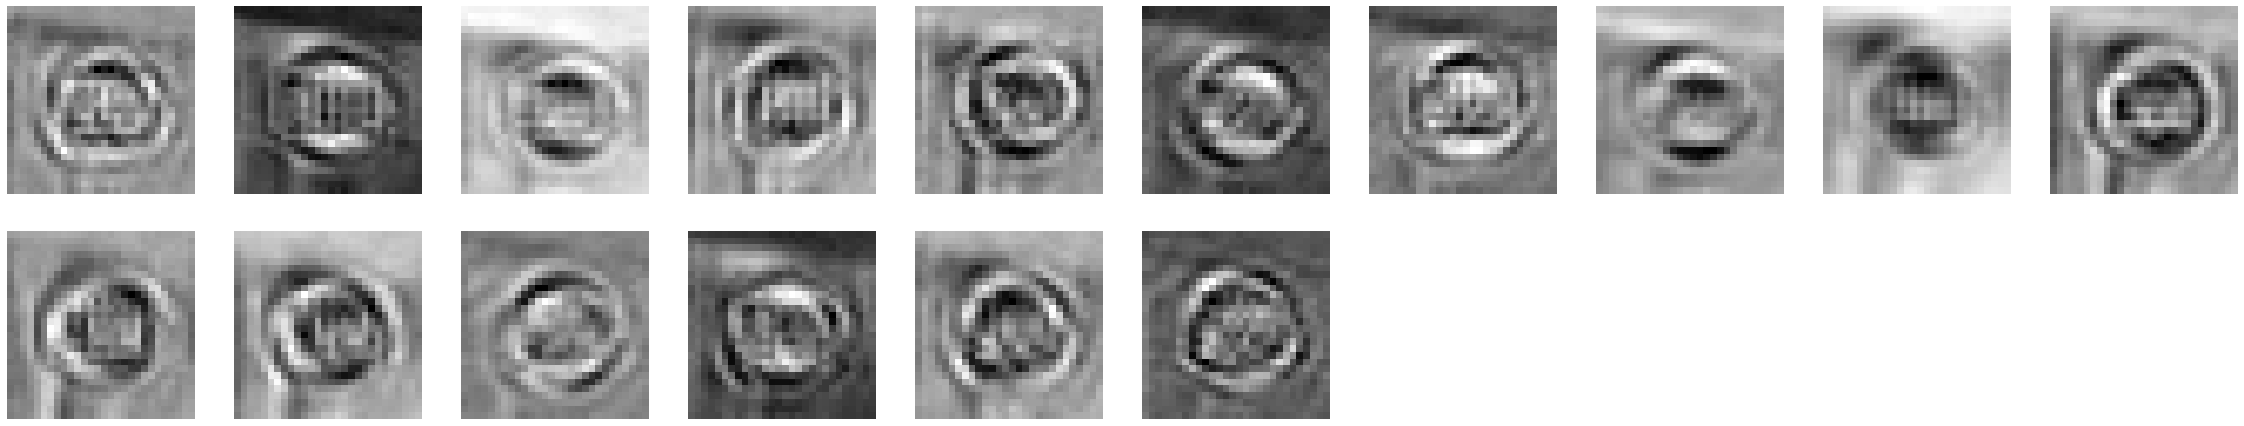

conv Layer  2


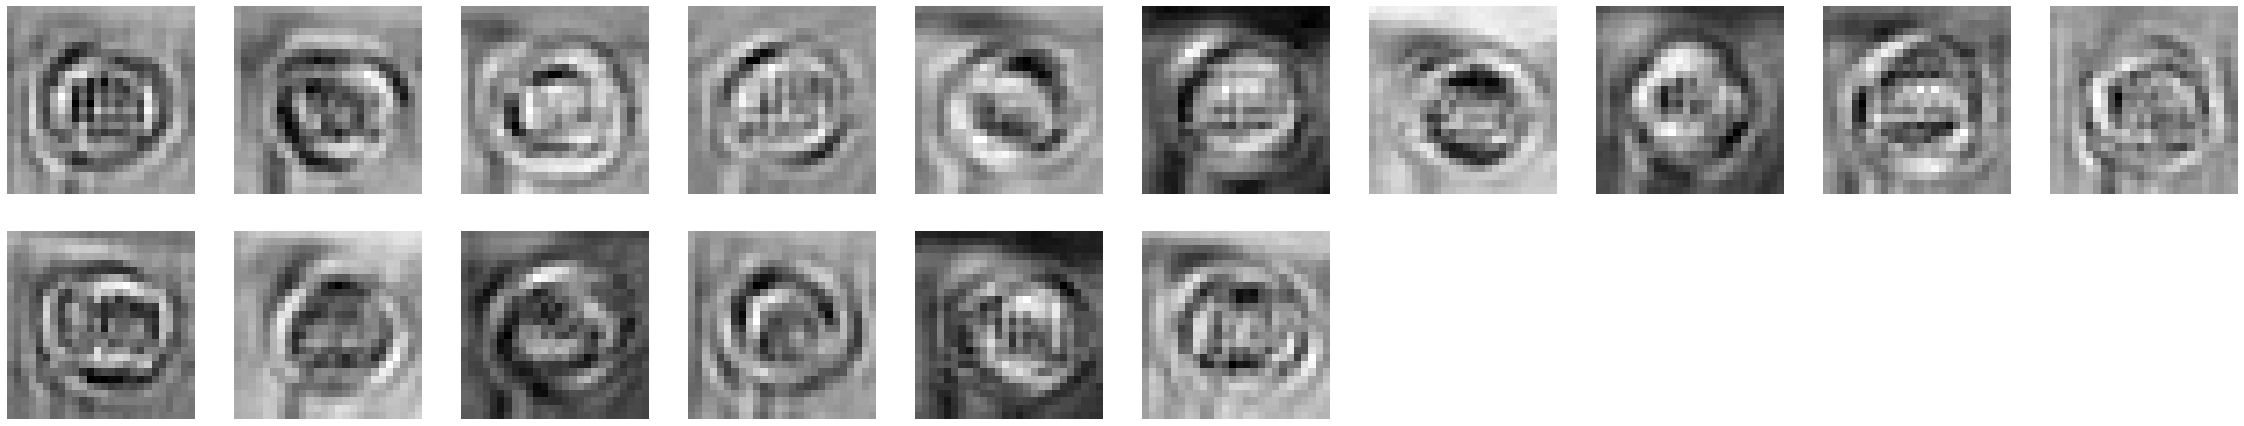

conv Layer  3


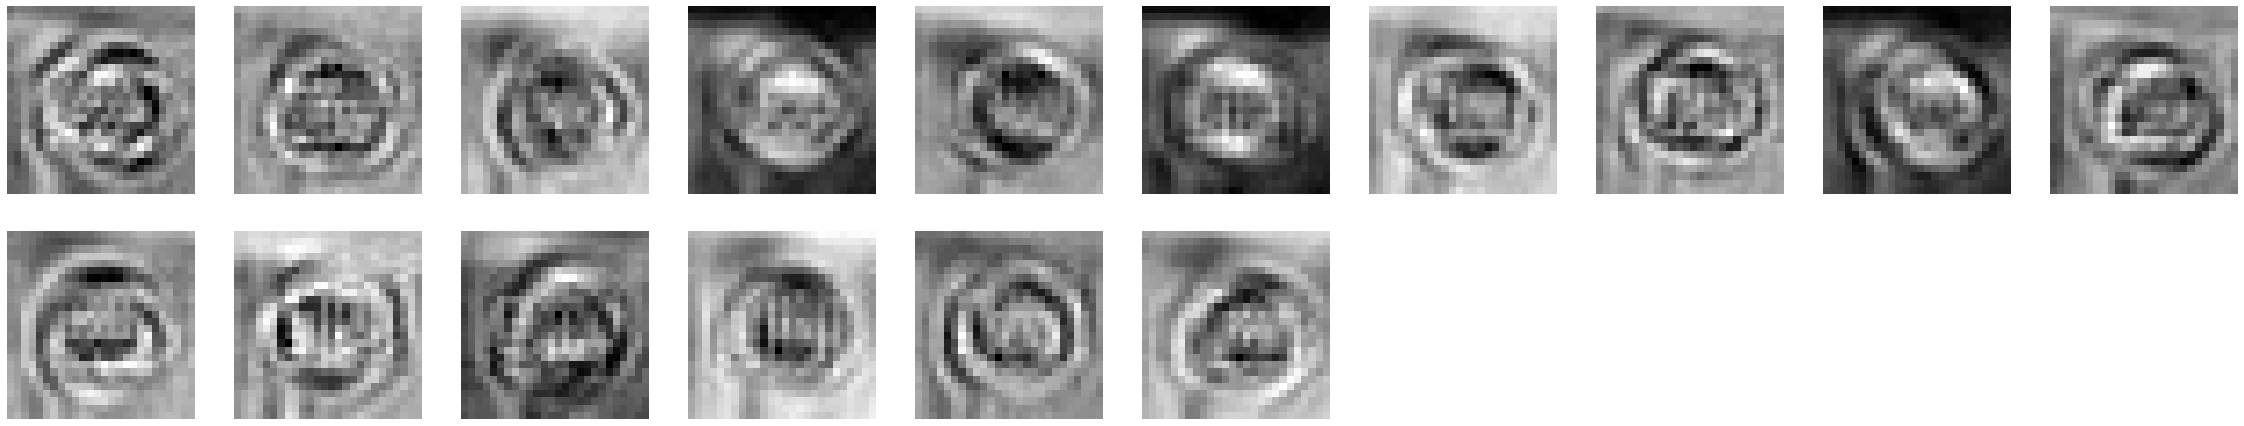

In [52]:
'''for num_layer in range(len(outputs)):
    plt.figure(figsize=(40, 20))
    layer_viz = outputs[num_layer][9, :, :, :].cpu()
    layer_viz = layer_viz.data
    #print('la', layer_viz.shape)
    print("conv Layer ", num_layer+1)
    for i, filter in enumerate(layer_viz):
        if i == 16: 
            break
        #print(filter.shape)
        plt.subplot(5, 10, i+1)
        plt.imshow(filter, cmap='gray')
        plt.axis("off")
    plt.show()
    plt.close()'''

In [54]:
'''optimizer = optim.Adam(model6.parameters(), lr=0.0001)
fit(n_epochs, model6, criterion, optimizer, train_loader, valid_loader)'''

'optimizer = optim.Adam(model6.parameters(), lr=0.0001)\nfit(n_epochs, model6, criterion, optimizer, train_loader, valid_loader)'

In [ ]:
'''check_point = torch.load('Model.pt', map_location=device)
model6.load_state_dict(check_point)
evaluate(model6, criterion, test_loader)'''

## Visualizing the STN results

In [ ]:
'''def visualize_stn():
    with torch.no_grad():
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_tensor = model.stn(data).cpu()

        input_grid = convert_image_np(make_grid(input_tensor))
        transformed_grid = convert_image_np(make_grid(transformed_tensor))

        # Plot the results side-by-side
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches((16, 16))
        ax[0].imshow(input_grid)
        ax[0].set_title('Dataset Images')
        ax[0].axis('off')

        ax[1].imshow(transformed_grid)
        ax[1].set_title('Transformed Images')
        ax[1].axis('off')
        
visualize_stn()'''